In [11]:
# pip install import-ipynb ipynb asyncio fastapi boto3 awscli psycopg2 sqlalchemy pandas tkcalendar

In [12]:
# pip install plotly python-dateutil

In [17]:
# Importing necessary packages to display header and footer
from IPython.core.display import HTML

# Displays the html header from HTML_code notebook 
with open('html_files/html_header.html', 'r') as file:
    html_header = file.read()
display(HTML(html_header))

In [18]:
# Importing necessary packages to connect to and display database
import pandas as pd
import psycopg2
import sqlalchemy
from sqlalchemy import create_engine
import matplotlib.pyplot as plt 
import numpy as np
import ipywidgets as widgets 
from IPython.display import display, clear_output

# Establishing Database Connection Details
hostname = 'vcm-41368.vm.duke.edu'
port = '8432'
dbname = 'postgres'
username = 'postgres'
password = 'change-this-password'

# Connecting to Database
connect_string = 'postgresql://' + username + ':' + password + '@' + hostname + ':' + port + '/'+ dbname
engine = sqlalchemy.create_engine(connect_string)

# Using Pandas to Query and Return Results from Database in a Dataframe
df = pd.read_sql_query('select * from command_results ORDER BY id DESC LIMIT 50',con=engine)


In [19]:
# # import pandas.io.sql as sqlio
# import warnings
# warnings.filterwarnings('ignore')

conn = psycopg2.connect(
    host="vcm-41368.vm.duke.edu",
    port = "8432",
    database="postgres",
    user="postgres",
    password="change-this-password",
    # connect_timeout=10  # Set a connection timeout of 10 seconds
)


def query_database(query, engine):
    return pd.read_sql_query(query, con=engine)

# Create text boxes for filtering
id_filter = widgets.Text(description='ID')
date_filter = widgets.Text(description='Date')


# date_filter = widgets.DatetimePicker(
#                 description='Date',
#                 disabled=False
#                 )


name_filter = widgets.Text(description='Name')
email_filter = widgets.Text(description='Email')
institution_filter = widgets.Text(description='Institution')
command_filter = widgets.Text(description='Command')
stderr_filter = widgets.Text(description='Error')
consent_filter = widgets.Text(description='Consent')
input_filter = widgets.Text(description='Input')
output_filter = widgets.Text(description='output')

# Button to apply filters
filter_button = widgets.Button(description='Apply Filters')

# Output widget
output = widgets.Output()

def display_data(change=False):
    with output:
        clear_output()
        
        # Construct the SQL query based on filter inputs
        conditions = []
        if id_filter.value:
            conditions.append(f"id = '{id_filter.value}'")
        if date_filter.value:
            conditions.append(f"date ILIKE '%{date_filter.value}%'")

        # if date_filter.value:
        #     date_str = date_filter.value.strftime('%Y-%m-%d')
        #     conditions.append(f"DATE(date) = '{date_str}'")


        
        if name_filter.value:
            conditions.append(f"name ILIKE '%{name_filter.value}%'")
        if email_filter.value:
            conditions.append(f"email ILIKE '%{email_filter.value}%'")
        if institution_filter.value:
            conditions.append(f"institution ILIKE '%{institution_filter.value}%'")
        if command_filter.value:
            conditions.append(f"command ILIKE '%{command_filter.value}%'")
        if stderr_filter.value:
            conditions.append(f"stderr ILIKE '%{stderr_filter.value}%'")
        if consent_filter.value:
            conditions.append(f"consent ILIKE '%{consent_filter.value}%'")
        if input_filter.value:
            conditions.append(f"input ILIKE '%{input_filter.value}%'")
        if output_filter.value:
            conditions.append(f"output ILIKE '%{output_filter.value}%'")

        where_clause = ' AND '.join(conditions) if conditions else '1=1'
        query = f'SELECT * FROM command_results WHERE {where_clause} ORDER BY id DESC LIMIT 10'
        
        try:
            with engine.begin() as conn:
                df = pd.read_sql_query(sqlalchemy.text(query), conn)
            # df = query_database(query, conn)
            display(df)
        except Exception as e:
            print(f"Error executing query: {e}")

filter_button.on_click(display_data)

# # Display filter widgets and output
# filter_widgets = widgets.VBox([
#     id_filter, name_filter, email_filter, institution_filter, command_filter,
#     stderr_filter, consent_filter, input_filter, output_filter, filter_button
# ])

# display(filter_widgets, output)

# Arrange filters in two columns
left_column = widgets.VBox([id_filter, date_filter, name_filter, email_filter, institution_filter,])
right_column = widgets.VBox([command_filter, stderr_filter, consent_filter, input_filter, output_filter])
filter_widgets = widgets.VBox([filter_button])
filters_box = widgets.VBox([widgets.HBox([left_column, right_column]), filter_widgets])

# Display the filter widgets and output
display(filters_box, output)

Output()


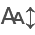

In [20]:
#This cell is s3 code, gets downloaable links
import boto3
from IPython.display import display, HTML, IFrame, Javascript
s3 = boto3.client('s3')
s3_resource = boto3.resource('s3')

bucket_name = 'duess-polypeptides'
content_folder = 'content_files'

# Function to upload content directly to S3
def save_content_to_s3(content, filename):
    s3_path = f"{content_folder}/{filename}"
    s3_resource.Object(bucket_name, s3_path).put(Body=str(content))
    return generate_signed_url(bucket_name, s3_path, expiration=86400)

# Function to generate a signed URL for an S3 object
def generate_signed_url(bucket_name, file_key, expiration=86400):
    return s3.generate_presigned_url('get_object',
                                     Params={'Bucket': bucket_name, 'Key': file_key},
                                     ExpiresIn=expiration)

# Function to handle the content and create the signed URL
def handle_content(row):
    filename = f"{row['id']}_content.txt"
    content = row['content']
    if pd.notnull(content):  # Check if content is not null
        try:
            url = save_content_to_s3(content, filename)
            return f'<a href="{url}" target="_blank">{row["id"]}_content</a>'
        except Exception as e:
            print(f"Error uploading content for {row['id']}: {e}")
            return "Error uploading content"
    else:
        return "No content"

# Function to handle the input and create the signed URL
def handle_input(row):
    filename = f"{row['id']}_input.txt"
    input_data = row['input']
    try:
        url = save_content_to_s3(input_data, filename)
        return f'<a href="{url}" target="_blank">{row["id"]}_input</a>'
    except Exception as e:
        print(f"Error uploading input for {row['id']}: {e}")
        return "Error uploading input"

# Apply the function to save content and input to S3 and create links
df['content'] = df.apply(handle_content, axis=1)
df['input'] = df.apply(handle_input, axis=1)

from itables import init_notebook_mode, show
init_notebook_mode(all_interactive=False)

show(df)


In [21]:
# Creates the save button --> save df to a CSV file
# def save():
#     df.to_csv('admin_data.csv', index=False)
#     #display(FileLink('admin_data.csv'))
#     display(HTML(f'<a href="admin_data.csv" target="_blank">Download CSV</a>'))
from IPython.display import display, HTML, IFrame, Javascript
def save_to_csv():
    global df
    df.to_csv('admin_data.csv', index=False)
    # display(HTML(f'<a href="admin_data.csv" download="admin_data.csv" target="_blank">Download CSV</a>'))

# Function to upload CSV to Amazon S3
def upload_to_s3():
    try:
        with open('admin_data.csv', 'rb') as data:
            s3.upload_fileobj(data, bucket_name, 'admin_data.csv')
        print('File uploaded successfully to S3.')
    except Exception as e:
        print(f'Error uploading file to S3: {e}')

button = widgets.Button(
    description="Download as CSV",
    tooltip="Click to download data",
    button_style="info"  # 'success', 'info', 'warning', 'danger' or ''
)

# def on_click(b):
#     save()

# def on_save_click(b):
#     save_to_csv()
#     upload_to_s3()
#     # Generate signed URL and assign it to the button's on_click event
#     url = generate_signed_url(bucket_name, 'admin_data.csv')
#     display(HTML(f'<script>'
#                  f'var link = document.createElement("a");'
#                  f'link.href = "{url}";'
#                  f'link.download = "admin_data.csv";'
#                  f'link.click();'
#                  f'</script>'))


# button.on_click(on_save_click)
# display(button)

# url = save_content_to_s3(content, filename)
#             return f'<a href="{url}" target="_blank">{row["id"]}_content</a>'


# bucket_name = 'duess-polypeptides'
csv_path = 'admin_data.csv'
# # Function to save the CSV file and generate a signed URL
# def prepare_download():
#     save_to_csv()
#     upload_to_s3()
#     url = generate_signed_url(bucket_name, csv_path)
#     return url

# # Generate the signed URL
# signed_url = prepare_download()

# # Read the HTML content from the file
# with open('download_button.html', 'r') as file:
#     html_content = file.read()

# # Replace the placeholder with the actual signed URL
# html_content_with_url = html_content.replace("{signed_url}", signed_url)

# # Display the button with the signed URL
# display(HTML(html_content_with_url))


def csv_s3():
    s3_client = boto3.client('s3')
    try:
        with open('admin_data.csv', 'rb') as data:
            s3.upload_fileobj(data, bucket_name, 'admin_data.csv')
            url = s3_client.generate_presigned_url('get_object',
                                               Params={'Bucket': bucket_name, 'Key': csv_path},
                                               ExpiresIn=3600)
        return url
    except NoCredentialsError:
        print("Credentials not available")
        return None

# Function to save the CSV file and generate a signed URL
def prepare_download():
    save_to_csv()
    upload_to_s3()
    url = csv_s3()
    return url

# Generate the signed URL
signed_url = prepare_download()

# Read the HTML content from the file
with open('html_files/download_button.html', 'r') as file:
    html_content = file.read()

# Replace the placeholder with the actual signed URL
html_content_with_url = html_content.replace("{signed_url}", signed_url)

# Display the button with the signed URL
display(HTML(html_content_with_url))
# display(HTML(f'<script>window.open("{signed_url}", "_blank");</script>'))


# Display the DataFrame with clickable links
# HTML(df.to_html(escape=False))

File uploaded successfully to S3.


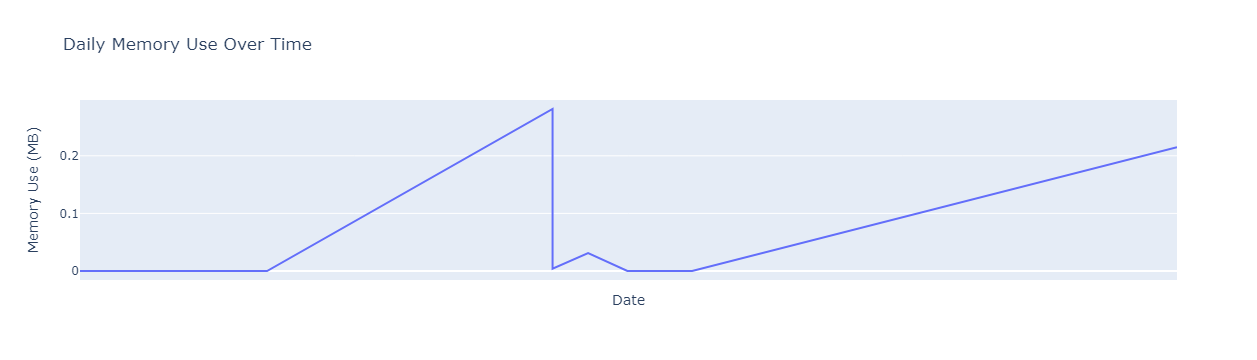

In [23]:
import plotly.express as px
from datetime import datetime

# Check if 'date' and 'memory_use' columns exist
if 'date' in df.columns and 'memory_use' in df.columns:
    # Extract columns and make a copy to avoid modifying the original dataframe
    data = df[['date', 'memory_use']].copy()
    
    # Convert 'date' column to datetime, coercing errors
    data['date'] = pd.to_datetime(data['date'], errors='coerce')
    
    # Ensure 'memory_use' is numeric, coercing errors
    data['memory_use'] = pd.to_numeric(data['memory_use'], errors='coerce')
    
    # Drop rows with NaN values in either 'date' or 'memory_use'
    data = data.dropna(subset=['date', 'memory_use'])
    
    # Filter out rows where 'date' or 'memory_use' contains the string 'string'
    data = data[~data['date'].astype(str).str.contains('string', na=False)]
    
    # Extract 'date' and 'memory_use' into lists
    dates = data['date'].tolist()
    memory_use = data['memory_use'].tolist()
    
    # Create a DataFrame from the lists for plotting
    data_for_plot = pd.DataFrame({'date': dates, 'memory_use': memory_use})
    
    # Create an interactive line plot using Plotly Express
    fig = px.line(data_for_plot, x='date', y='memory_use', 
                  title='Daily Memory Use Over Time', 
                  labels={'date': 'Date', 'memory_use': 'Memory Use (MB)'})
    
    fig.update_xaxes(dtick='M7', tickformat='%d-%b-%Y')  # Customize x-axis date format
    
    # Display the plot
    fig.show()


    
# Displays the HTML footer from HTML_code notebook
with open('html_files/html_footer.html', 'r') as file:
    html_footer = file.read()
display(HTML(html_footer))

In [ ]:
# Closing Connnection to Database
engine.dispose()